In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexTorchCombinator import ConvexTorchCombinator
from convexmtl_torch.model.utils import NeuralNetwork

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from copy import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of convexmtl_torch.model.utils failed: Traceback (most recent call last):
  File "/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/carlos/anaconda3/envs/rkm/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/carlos/anaconda3/envs/rkm/lib/python3.9/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
  File "<frozen importlib._bootstrap>", line 925, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1414, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1380, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1246, in __iter__
  File "<frozen im

In [37]:
class MTLFunctionsRegression():
    """
    A class to generate a synthetic regression dataset.

    Parameters
    ----------
    n_samples : int
        The number of samples to generate.
    noise : float
        The standard deviation of the Gaussian noise to add to the target.
    random_state : int or None
        The seed to use for the random number generator.
    """

    def __init__(self, n_samples_per_task=25, noise=0.1, n_tasks=4, random_state=42, start=1., stop=10.):
        self.n_samples_per_task = n_samples_per_task
        self.noise = noise
        self.n_tasks = n_tasks
        self.random_state = random_state
        self.start = start
        self.stop = stop
        np.random.seed(self.random_state)
        self.task_functions = self._generate_task_functions()
        self.X, self.y = self._generate_data()

    
    def _function_task(self, x, t=None):
        y = np.sin(x)
        if t is not None:
            y += (1e-6 * self.poly_tasks[t](x))
        return y

    def _generate_task_functions(self):
        self.poly_tasks = {}
        for t in range(self.n_tasks):
            shape = np.random.randint(1, 10, size=1)
            coefs = np.random.randn(shape[0])
            self.poly_tasks[t] = np.poly1d(coefs)

        ic(self.poly_tasks)

        task_functions = {}
        for t in range(self.n_tasks):
            task_functions[t] = (lambda x: self._function_task(x, t=t))

        return task_functions

    def _generate_data(self):
        """
        Generate the synthetic data.
        """        
        m_t = self.n_samples_per_task
        N = m_t * self.n_tasks
        
        x_l = []
        y_l = []
        t_l = []
        dic_w = {}

        rng = np.random.RandomState(self.random_state)

        for t in range(self.n_tasks):            
            f_t = self.task_functions[t]
            x_task = np.linspace(self.start, self.stop, m_t)[:, None]

            ic(x_task.shape)
            
            y_task = self._function_task(x_task, t) + + rng.randn(self.n_samples_per_task)[:, None] * self.noise
            t_task = t * np.ones(y_task.shape)

            x_l.append(x_task)
            y_l.append(y_task)
            t_l.append(t_task)


        X_data = np.concatenate(x_l, axis=0)
        t = np.concatenate(t_l, axis=0)
        X = np.concatenate((X_data, t), axis=1)
        y = np.concatenate(y_l, axis=0).flatten()

        return X, y

    def generate_new_data(self, n_samples_per_task=None, n_tasks=None, noise=None, random_state=None):
        """
        Generates new dataset with given parameters.
        """
        if n_samples_per_task is None:
            n_samples_per_task = self.n_samples_per_task
        if n_tasks is None:
            n_tasks = self.n_tasks
        if noise is None:
            noise = self.noise
        if random_state is None:
            random_state = self.random_state
        self.n_samples_per_task = n_samples_per_task
        self.n_tasks = n_tasks
        self.noise = noise
        self.random_state = random_state
        self.X, self.y = self._generate_data()

    def plot_functions(self, ax=None):
        x_linsp = np.linspace(self.start, self.stop)
        if ax is None:
            fig = plt.figure(figsize=(12, 7))
            ax = plt.gca()
        # plt.plot(np.linspace(self.start, self.stop), f(np.linspace(self.start, self.stop)), color='black', label='sin(x)')
        for t in range(self.n_tasks):
            f_t = self.task_functions[t]
            ax.plot(x_linsp, self._function_task(x_linsp, t), color=cm.tab10(t), linestyle='--')
            #plt.scatter(data_x[i*m_r:(i+1)*m_r], data_y[i*m_r:(i+1)*m_r], label='task {}'.format(t), color=cm.tab10(t))

        plt.legend()
        # plt.title('Multi-Task Toy Problem'.format(data_name))
        # plt.tight_layout()
        # plt.savefig('toyproblem_{}.pdf'.format(data_name))

    def plot_data(self, X, y, ax=None):
        if ax is None:
            fig = plt.figure(figsize=(12, 7))
            ax = plt.gca()
        # plt.plot(np.linspace(self.
        X_data = X[:, :-1]
        t_col = X[:, -1]
        for t in range(self.n_tasks):
            t_idx = (t_col == t)
            ax.scatter(X_data[t_idx], y[t_idx], color=cm.tab10(t))
            #plt.scatter(data_x[i*m_r:(i+1)*m_r], data_y[i*m_r:(i+1)*m_r], label='task {}'.format(t), color=cm.tab10(t))

        plt.legend()
        # plt.title('Multi-Task Toy Problem'.format(data_name))
        # plt.tight_layout()
        # plt.savefig('toyproblem_{}.pdf'.format(data_name))

    def plot_data_functions(self, X, y, ax=None):
        if ax is None:
            fig = plt.figure(figsize=(12, 7))
            ax = plt.gca()
        self.plot_data(X, y, ax=ax)
        self.plot_functions(ax=ax)

Epoch 446: 100%|██████████| 3/3 [20:09<00:00, 403.18s/it, loss=0.499, v_num=81]


In [38]:
mtlds = MTLFunctionsRegression()

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| self.poly_tasks: {0: poly1d([-0.55023449,  0.51543307,  0.47386083,  1.36845012, -0.91682684,
                            -0.12414718, -2.01096289]),
                      1: poly1d([-0.49280342, -0.58087813, -0.52516981, -0.57138017, -0.92408284,
                            -2.61254901,  0.95036968,  0.81644508]),
                      2: poly1d([-1.523876  ,  0.1424646 , -0.03465218]),
                      3: poly1d([ 0.12221917, -0.51543566, -0.60025385,  0.94743982,  0.291034  ,
                            -0.63555974, -1.02155219, -0.16175539, -0.5336488 ])}
ic| x_task.shape: (25, 1)
ic| x_task.shape: (25, 1)
ic| x_task.shape: (25, 1)
ic| x_task.shape: (25, 1)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


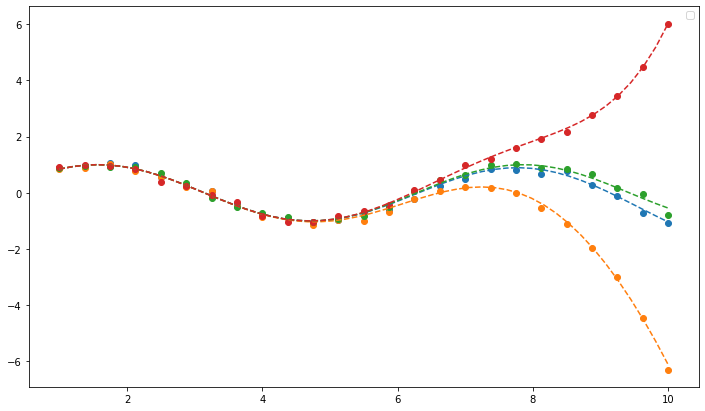

In [39]:
mtlds.plot_data_functions(X, y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [41]:
X_train, t_train = X_train[:,:-1], X_train[:,-1]
X_test, t_test = X_test[:,:-1], X_test[:,-1]
X_train, t_train, y_train = map(torch.tensor, (X_train, t_train, y_train))
X_train, t_train, y_train = map(lambda obj: obj.float(), [X_train, t_train, y_train])
X_test, t_test, y_test = map(torch.tensor, (X_test, t_test, y_test))
X_test, t_test, y_test = map(lambda obj: obj.float(), [X_test, t_test, y_test])


In [42]:
# train_ds = TensorDataset(X_train, t_train, y_train)
train_ds = TensorDataset(X_train, t_train, y_train)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)



In [43]:
model = ConvexTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=range(4), lamb=0)
# model = NeuralNetwork(n_features=1)

In [44]:
trainer = Trainer(max_epochs=1000)

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 8.5 K 
-------------------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: T

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 64.08it/s, loss=0.265, v_num=84] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 50.65it/s, loss=0.265, v_num=84]


In [45]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [46]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(33, 1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


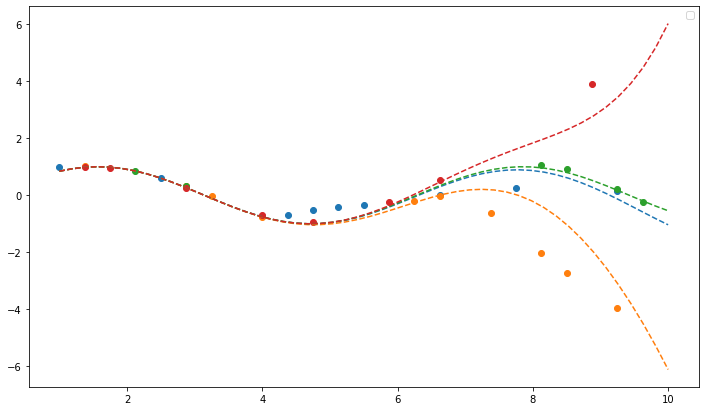

In [47]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)